# Direct Model
## Setup

In [1]:
from data_utils import *
from train import * 

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

import torch
from torch import nn, optim
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.models as models

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

use_cuda = torch.cuda.is_available()
print("GPU Available:", use_cuda)
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

# dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
dtype = torch.float32

print('using device:', device)

GPU Available: True
using device: cuda:0


## Load Dataset

In [2]:
data = load_bolete_data()
print()
for k in data.keys():
    print(k, np.shape(data[k]))

ItemsViewHDF5(<HDF5 file "bolete.h5" (mode r)>)

bolete-characteristics (38, 1868)
bolete-edibility (5, 1868)
bolete-images (3, 512, 512, 1868)
bolete-labels (1868,)


## Split into train and test

In [3]:
X_train, X_test, Y_train, Y_test = get_train_and_test(data, "bolete-labels")
N, H, W, C = X_train.shape
M = np.size(np.unique(Y_train))

Y_train = Y_train.astype(np.long)
Y_test = Y_test.astype(np.long)

X_train = np.transpose(X_train,[0,3,1,2])
print(X_train.shape)

(1307, 3, 512, 512)


In [4]:
assert((np.unique(Y_train) == np.unique(Y_test)).all(), 
"Classes are not split between train and test appropriately.")

## Define models

In [5]:
def simple_model():
    # copy final model from ass igment 2
    def flatten(x):
        """Flattens to [N, -1] where -1 is whatever it needs to be"""
        N = x.shape[0] # read in N, C, H, W
        return x.view(N, -1)  
        # "flatten" the C * H * W values into a single vector per image
    class Flatten(nn.Module):
        def forward(self, x):
            return flatten(x)

    channel_1 = 32
    channel_2 = 24
    channel_3 = 16
    hidden_dim = 150
    learning_rate = 3e-3 # 1e-2

    model = nn.Sequential(
        nn.Conv2d(C, channel_1, kernel_size=5, padding=2),
        # nn.GroupNorm(4,channel_1),
        nn.BatchNorm2d(channel_1),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Conv2d(channel_1, channel_2, kernel_size=3, padding=1),
        # nn.GroupNorm(4,channel_2),
        nn.BatchNorm2d(channel_2),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Conv2d(channel_2, channel_3, kernel_size=3, padding=1),
        # nn.GroupNorm(4,channel_3),
        nn.BatchNorm2d(channel_3),
        nn.ReLU(),
        nn.Dropout(0.1),
        Flatten(),
        nn.Linear(channel_3 * H * W, hidden_dim),
        nn.ReLU(),
        nn.Linear(hidden_dim, M)
    )
    
    return model

def freeze(model):
    for param in model.parameters():
        param.requires_grad = False
    return model

def modified_alexnet():
    model = models.alexnet(pretrained=True)
    model = freeze(model)

    # model.classifier[0] = ???
    model.classifier[6] = nn.Linear(in_features=4096, out_features=M, bias=True)
    print(model)
    return model

def modified_googlenet():
    model = models.googlenet(pretrained=True)
    model = freeze(model)

    model.fc = nn.Linear(in_features=1024, out_features=M, bias=True)
    print(model)
    return model

## Define the loss function

In [6]:
loss_fn = nn.CrossEntropyLoss()

def pred_fn(scores):
    m = nn.Softmax(dim=1)
    return torch.argmax(m(scores), dim=1)

## Cross Validate on training data

In [15]:
# model = simple_model()
# model = modified_alexnet()
model = modified_googlenet()
optimizer = optim.RMSprop(
    model.parameters(),
    lr=1e-3,
    momentum=0.4,
    alpha=0.99
    )

transform = T.Compose([T.ToTensor()])


torch.manual_seed(0)
history = cross_val(
    X_train=X_train,
    Y_train=Y_train,
    model=model,
    optimizer=optimizer,
    loss_fn=loss_fn,
    pred_fn=pred_fn,
    batch_size=8,
    num_epochs=100,
    show_every=1,
    folds=1,
    test_size=0.3,
    device=device,
    dtype=dtype,
    transform=transform,
)

ias=False)
      (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (branch2): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(256, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(128, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(128, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (branch3): Sequential(
      (0): BasicConv2d(
        (conv): Conv2d(256, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicConv2d(
        (conv): Conv2d(32, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.1, affine=True, track_run

## Plot Training History

Text(0, 0.5, 'Accuracy')

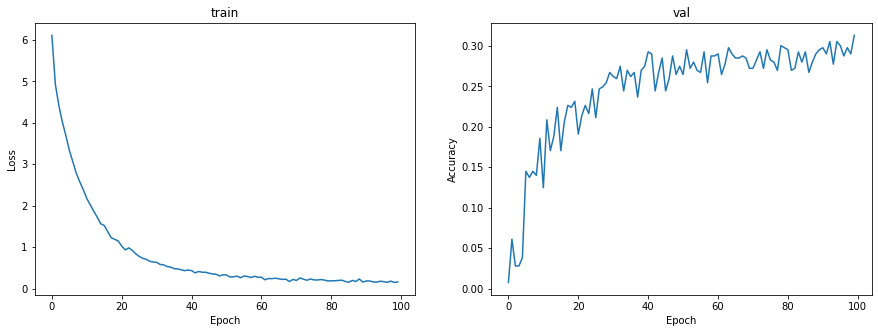

In [16]:
fig, axes = plt.subplots(1, 2, figsize=[15,5], sharex=False, sharey=False)

plotnum = 0
for a in ["train", "val"]:
    # ax1 = fig.add_subplot(120 + plotnum)
    axes[plotnum].set_title(a)
    axes[plotnum].set_xlabel("Epoch")
    for i in range(len(history[a])):
        axes[plotnum].plot(history[a][i])
    plotnum += 1
axes[0].set_ylabel("Loss")
axes[1].set_ylabel("Accuracy")

### Check status of GPU Memory for Debugging Purposes

In [9]:
import torch
import gc
for obj in gc.get_objects():
    try:
        if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
            print(type(obj), obj.size())
    except:
        pass

<class 'torch.nn.parameter.Parameter'> torch.Size([64, 3, 7, 7])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 64, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([192, 64, 3, 3])
<class 'torch.nn.parameter.Parameter'> torch.Size([192])
<class 'torch.nn.parameter.Parameter'> torch.Size([192])
<class 'torch.nn.parameter.Parameter'> torch.Size([64, 192, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([64])
<class 'torch.nn.parameter.Parameter'> torch.Size([128, 256, 1, 1])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([128])
<class 'torch.nn.parameter.Parameter'> torch.Size([96, 192, 1, 1])
<class 'torch.nn.parameter.Parameter